In [1]:
pip install git+https://github.com/google-research/timesfm


  Cloning https://github.com/google-research/timesfm to /tmp/pip-req-build-2wslxrwo
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/timesfm /tmp/pip-req-build-2wslxrwo
  Resolved https://github.com/google-research/timesfm to commit dbe0fa528d58aa2946a88125a102a3417fe664b6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_nvjitlink_cu12-12.6.20-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of googleapis-common-protos to determine which version is compatible with other requireme

In [1]:
!pip install yfinance
!pip install utilsforecast


In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['JAX_PMAP_USE_TENSORSTORE'] = 'false'

In [3]:
import timesfm
import gc
import numpy as np
import pandas as pd
from timesfm import patched_decoder
from timesfm import data_loader
import yfinance as yf

In [4]:
from tqdm import tqdm
import dataclasses
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [5]:
# Loading TimesFM pretrained checkpoint
tfm = timesfm.TimesFm(
    context_len=64,
    horizon_len=1,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend="gpu",
)
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

(…)nts/checkpoint_1100000/metadata/metadata:   0%|          | 0.00/43.9k [00:00<?, ?B/s]

(…)oint_1100000/descriptor/descriptor.pbtxt:   0%|          | 0.00/499 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

checkpoint:   0%|          | 0.00/814M [00:00<?, ?B/s]

Constructing model weights.


Constructed model weights in 3.51 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 1.54 seconds.
Jitting decoding.
Jitted decoding in 23.90 seconds.


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np

# انتخاب نماد سهام (مثال: AAPL برای اپل)
ticker = 'AAPL'

# بارگذاری داده‌های بورسی روزانه
data = yf.download(ticker, start='1900-01-01', end='2023-01-01', interval='1d')
data = data.resample('1D').ffill()
data.reset_index(inplace=True)  # تبدیل شاخص به ستون

# تغییر نام ستون‌ها
data.rename(columns={'Date': 'date', 'Close': 'y'}, inplace=True)

# انتخاب ستون‌های مناسب
ts_cols = ["Open", "High", "Low", "y", "Volume"]

# محاسبه ویژگی‌های اضافی
data['MA_10'] = data['y'].rolling(window=10).mean()
data['MA_50'] = data['y'].rolling(window=50).mean()
data['RSI'] = 100 - (100 / (1 + data['y'].pct_change().rolling(window=14).apply(lambda x: (x[x > 0].mean() / -x[x < 0].mean()) if x[x < 0].mean() != 0 else np.inf)))



# انتخاب ستون‌های نهایی
final_cols = ["date", "Open", "High", "Low", "y", "Volume", "MA_10", "MA_50", "RSI"]
data = data[final_cols]

# ذخیره‌سازی داده‌ها در یک فایل CSV
data_path = 'stock_data.csv'
data.to_csv(data_path, index=False)

print(f"Number of records: {len(data)}")


[*********************100%%**********************]  1 of 1 completed


Number of records: 15359


In [7]:
freq = 'D'
context_len = 64
pred_len = 1
batch_size = 14

# Define train, validation, and test boundaries
train_boundary = int(len(data) * 0.7)
val_boundary = int(len(data) * 0.85)

In [8]:
train_boundary

10751

In [9]:
data

,date,Open,High,Low,y,Volume,MA_10,MA_50,RSI
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,469033600,NaN,NaN,NaN
1,1980-12-13,0.128348,0.128906,0.128348,0.128348,469033600,NaN,NaN,NaN
2,1980-12-14,0.128348,0.128906,0.128348,0.128348,469033600,NaN,NaN,NaN
3,1980-12-15,0.122210,0.122210,0.121652,0.121652,175884800,NaN,NaN,NaN
4,1980-12-16,0.113281,0.113281,0.112723,0.112723,105728000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
15354,2022-12-26,130.919998,132.419998,129.639999,131.860001,63814900,132.880998,143.267599,47.157830
15355,2022-12-27,131.380005,131.410004,128.720001,130.029999,69007800,132.432999,143.089799,58.728618
15356,2022-12-28,129.669998,131.029999,125.870003,126.040001,85438400,131.585999,142.820599,56.107847
15357,2022-12-29,127.989998,130.479996,127.730003,129.610001,75703700,131.310000,142.715399,64.109504


In [10]:
ts_cols = [col for col in data.columns if col != "date"]


num_ts = len(ts_cols)
# Create TimeSeriesdata loader
dtl = data_loader.TimeSeriesdata(
      data_path=data_path,
      datetime_col="date",
      num_cov_cols=None,
      cat_cov_cols=None,
      ts_cols=ts_cols,
      train_range=[0, train_boundary],
      val_range=[train_boundary, val_boundary],
      test_range=[val_boundary, len(data)],
      hist_len=context_len,
      pred_len=pred_len,
      batch_size=num_ts,  # Change as per requirement
      freq=freq,
      normalize=True,
      epoch_len=None,
      holiday=False,
      permute=True,
  )
train_batches = dtl.tf_dataset(mode="train", shift=1).batch(batch_size)
val_batches = dtl.tf_dataset(mode="val", shift=pred_len)
test_batches = dtl.tf_dataset(mode="test", shift=pred_len)

In [11]:
for tbatch in tqdm(train_batches.as_numpy_iterator()):
    pass
print(tbatch[0].shape)

1527it [00:08, 187.30it/s]

(8, 8, 64)


# MAE on the test split for the pretrained TimesFM model

In [12]:
mae_losses = []
for batch in tqdm(test_batches.as_numpy_iterator()):
    past = batch[0]

    actuals = batch[3]

    _, forecasts = tfm.forecast(list(past), [0] * past.shape[0])
    forecasts = forecasts[:, 0 : actuals.shape[1], 5]

    mae_losses.append(np.abs(forecasts - actuals).mean())

print(f"MAE: {np.mean(mae_losses)}")

2304it [00:38, 60.55it/s]


MAE: 0.3713320195674896


# Fine-tuning the model

In [13]:
import jax
from jax import numpy as jnp
from praxis import pax_fiddle
from praxis import py_utils
from praxis import pytypes
from praxis import base_model
from praxis import optimizers
from praxis import schedules
from praxis import base_hyperparams
from praxis import base_layer
from paxml import tasks_lib
from paxml import trainer_lib
from paxml import checkpoints
from paxml import learners
from paxml import partitioning
from paxml import checkpoint_types

In [14]:
NestedMap = py_utils.NestedMap
WeightInit = base_layer.WeightInit
WeightHParams = base_layer.WeightHParams
InstantiableParams = py_utils.InstantiableParams
JTensor = pytypes.JTensor
NpTensor = pytypes.NpTensor
WeightedScalars = pytypes.WeightedScalars
instantiate = base_hyperparams.instantiate
LayerTpl = pax_fiddle.Config[base_layer.BaseLayer]
AuxLossStruct = base_layer.AuxLossStruct

AUX_LOSS = base_layer.AUX_LOSS
template_field = base_layer.template_field

# Standard prng key names
PARAMS = base_layer.PARAMS
RANDOM = base_layer.RANDOM

key = jax.random.PRNGKey(seed=1234)

In [15]:
model = pax_fiddle.Config(
    patched_decoder.PatchedDecoderFinetuneModel,
    name='patched_decoder_finetune',
    core_layer_tpl=tfm.model_p,
)

In [16]:

@pax_fiddle.auto_config
def build_learner() -> learners.Learner:
  return pax_fiddle.Config(
      learners.Learner,
      name='learner',
      loss_name='avg_qloss',
      optimizer=optimizers.Adam(
          epsilon=1e-7,
          clip_threshold=1e2,
          learning_rate=1e-2,
          lr_schedule=pax_fiddle.Config(
              schedules.Cosine,
              initial_value=1e-3,
              final_value=1e-4,
              total_steps=40000,
          ),
          ema_decay=0.9999,
      ),
      # Linear probing i.e we hold the transformer layers fixed.
      bprop_variable_exclusion=['.*/stacked_transformer_layer/.*'],
  )

In [18]:

task_p = tasks_lib.SingleTask(
    name='ts-learn',
    model=model,
    train=tasks_lib.SingleTask.Train(
        learner=build_learner(),
    ),
)

In [19]:
task_p.model.ici_mesh_shape = [1, 1, 1]
task_p.model.mesh_axis_names = ['replica', 'data', 'mdl']

DEVICES = np.array(jax.devices()).reshape([1, 1, 1])
MESH = jax.sharding.Mesh(DEVICES, ['replica', 'data', 'mdl'])

num_devices = jax.local_device_count()
print(f'num_devices: {num_devices}')
print(f'device kind: {jax.local_devices()[0].device_kind}')

num_devices: 1
device kind: Tesla T4


In [26]:
jax_task = task_p
key, init_key = jax.random.split(key)

# To correctly prepare a batch of data for model initialization (now that shape
# inference is merged), we take one devices*batch_size tensor tuple of data,
# slice out just one batch, then run the prepare_input_batch function over it.


def process_train_batch(batch):
    past_ts = batch[0].reshape(len(batch[2]) * num_ts, -1)
    actual_ts = batch[3].reshape(len(batch[2]) * num_ts, -1)
    return NestedMap(input_ts=past_ts, actual_ts=actual_ts)


def process_eval_batch(batch):
    past_ts = batch[0]
    actual_ts = batch[3]
    return NestedMap(input_ts=past_ts, actual_ts=actual_ts)


jax_model_states, _ = trainer_lib.initialize_model_state(
    jax_task,
    init_key,
    process_train_batch(tbatch),
    checkpoint_type=checkpoint_types.CheckpointType.GDA,
)

In [27]:
jax_model_states.mdl_vars['params']['core_layer'] = tfm._train_state.mdl_vars['params']
jax_vars = jax_model_states.mdl_vars
gc.collect()

0

In [28]:
jax_task = task_p


def train_step(states, prng_key, inputs):
  return trainer_lib.train_step_single_learner(
      jax_task, states, prng_key, inputs
  )


def eval_step(states, prng_key, inputs):
  states = states.to_eval_state()
  return trainer_lib.eval_step_single_learner(
      jax_task, states, prng_key, inputs
  )

key, train_key, eval_key = jax.random.split(key, 3)
train_prng_seed = jax.random.split(train_key, num=jax.local_device_count())
eval_prng_seed = jax.random.split(eval_key, num=jax.local_device_count())

p_train_step = jax.pmap(train_step, axis_name='batch')
p_eval_step = jax.pmap(eval_step, axis_name='batch')

In [32]:
replicated_jax_states = trainer_lib.replicate_model_state(jax_model_states)
replicated_jax_vars = replicated_jax_states.mdl_vars

In [33]:
best_eval_loss = 1e7
step_count = 0
patience = 0
NUM_EPOCHS = 100
PATIENCE = 5
TRAIN_STEPS_PER_EVAL = 1000
CHECKPOINT_DIR='/content'

In [34]:
def reshape_batch_for_pmap(batch, num_devices):
  def _reshape(input_tensor):
    bsize = input_tensor.shape[0]
    residual_shape = list(input_tensor.shape[1:])
    nbsize = bsize // num_devices
    return jnp.reshape(input_tensor, [num_devices, nbsize] + residual_shape)

  return jax.tree.map(_reshape, batch)

In [35]:
for epoch in range(NUM_EPOCHS):
    print(f"__________________Epoch: {epoch}__________________", flush=True)
    train_its = train_batches.as_numpy_iterator()
    if patience >= PATIENCE:
        print("Early stopping.", flush=True)
        break
    for batch in tqdm(train_its):
        train_losses = []
        if patience >= PATIENCE:
            print("Early stopping.", flush=True)
            break
        tbatch = process_train_batch(batch)
        tbatch = reshape_batch_for_pmap(tbatch, num_devices)
        replicated_jax_states, step_fun_out = p_train_step(
            replicated_jax_states, train_prng_seed, tbatch
        )
        train_losses.append(step_fun_out.loss[0])
        if step_count % TRAIN_STEPS_PER_EVAL == 0:
            print(
                f"Train loss at step {step_count}: {np.mean(train_losses)}",
                flush=True,
            )
            train_losses = []
            print("Starting eval.", flush=True)
            val_its = val_batches.as_numpy_iterator()
            eval_losses = []
            for ev_batch in tqdm(val_its):
                ebatch = process_eval_batch(ev_batch)
                ebatch = reshape_batch_for_pmap(ebatch, num_devices)
                _, step_fun_out = p_eval_step(
                    replicated_jax_states, eval_prng_seed, ebatch
                )
                eval_losses.append(step_fun_out.loss[0])
            mean_loss = np.mean(eval_losses)
            print(f"Eval loss at step {step_count}: {mean_loss}", flush=True)
            if mean_loss < best_eval_loss or np.isnan(mean_loss):
                best_eval_loss = mean_loss
                print("Saving checkpoint.")
                jax_state_for_saving = py_utils.maybe_unreplicate_for_fully_replicated(
                    replicated_jax_states
                )
                checkpoints.save_checkpoint(
                    jax_state_for_saving, CHECKPOINT_DIR, overwrite=True
                )
                patience = 0
                del jax_state_for_saving
                gc.collect()
            else:
                patience += 1
                print(f"patience: {patience}")
        step_count += 1

__________________Epoch: 0__________________


0it [00:00, ?it/s]

Train loss at step 0: 0.8262594938278198
Starting eval.



0it [00:00, ?it/s]
1it [00:11, 11.58s/it]
9it [00:11,  1.06it/s]
17it [00:11,  2.41it/s]
26it [00:11,  4.49it/s]
35it [00:11,  7.30it/s]
44it [00:12, 11.01it/s]
53it [00:12, 15.76it/s]
62it [00:12, 21.63it/s]
71it [00:12, 28.58it/s]
80it [00:12, 36.28it/s]
89it [00:12, 44.46it/s]
98it [00:12, 52.46it/s]
107it [00:12, 59.75it/s]
116it [00:12, 65.93it/s]
125it [00:13, 71.27it/s]
134it [00:13, 75.90it/s]
143it [00:13, 79.53it/s]
152it [00:13, 81.90it/s]
161it [00:13, 84.02it/s]
170it [00:13, 85.38it/s]
179it [00:13, 86.46it/s]
188it [00:13, 87.25it/s]
197it [00:13, 87.39it/s]
206it [00:13, 87.59it/s]
215it [00:14, 87.73it/s]
224it [00:14, 88.04it/s]
233it [00:14, 88.43it/s]
242it [00:14, 88.32it/s]
251it [00:14, 88.24it/s]
260it [00:14, 88.44it/s]
269it [00:14, 88.71it/s]
278it [00:14, 88.62it/s]
287it [00:14, 88.46it/s]
296it [00:14, 88.18it/s]
305it [00:15, 88.09it/s]
314it [00:15, 88.11it/s]
323it [00:15, 88.39it/s]
332it [00:15, 88.36it/s]
341it [00:15, 88.63it/s]
350it [00:15, 88.66

Eval loss at step 0: 1.020851731300354
Saving checkpoint.


        shapes of train_state  as the unpadded shapes.
999it [02:50, 11.76it/s]

Train loss at step 1000: 0.5257206559181213
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 91.92it/s]
20it [00:00, 90.36it/s]
30it [00:00, 89.72it/s]
40it [00:00, 89.86it/s]
49it [00:00, 89.57it/s]
58it [00:00, 89.37it/s]
67it [00:00, 89.31it/s]
76it [00:00, 89.14it/s]
85it [00:00, 88.09it/s]
94it [00:01, 87.66it/s]
103it [00:01, 88.07it/s]
112it [00:01, 88.56it/s]
121it [00:01, 88.46it/s]
130it [00:01, 88.91it/s]
139it [00:01, 88.85it/s]
148it [00:01, 89.01it/s]
157it [00:01, 89.08it/s]
166it [00:01, 89.03it/s]
175it [00:01, 88.45it/s]
184it [00:02, 88.14it/s]
193it [00:02, 88.44it/s]
202it [00:02, 88.32it/s]
211it [00:02, 88.43it/s]
220it [00:02, 88.41it/s]
229it [00:02, 88.66it/s]
238it [00:02, 88.73it/s]
247it [00:02, 88.95it/s]
256it [00:02, 88.77it/s]
265it [00:02, 88.42it/s]
274it [00:03, 88.38it/s]
283it [00:03, 88.37it/s]
292it [00:03, 88.45it/s]
301it [00:03, 88.72it/s]
310it [00:03, 88.65it/s]
319it [00:03, 88.55it/s]
328it [00:03, 88.51it/s]
337it [00:03, 88.81it/s]
346it [00:03, 88.77it/s]
355it [00:04, 88.55it/s]
364it [00:04, 8

Eval loss at step 1000: 0.992071270942688


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


1527it [05:02,  5.06it/s]

__________________Epoch: 1__________________



473it [00:42, 11.62it/s]

Train loss at step 2000: 0.8300904035568237
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 94.10it/s]
20it [00:00, 87.38it/s]
29it [00:00, 88.37it/s]
38it [00:00, 88.25it/s]
47it [00:00, 88.75it/s]
56it [00:00, 88.77it/s]
65it [00:00, 88.99it/s]
74it [00:00, 89.06it/s]
83it [00:00, 88.42it/s]
92it [00:01, 87.85it/s]
101it [00:01, 87.72it/s]
110it [00:01, 87.99it/s]
119it [00:01, 88.34it/s]
128it [00:01, 88.44it/s]
137it [00:01, 88.75it/s]
146it [00:01, 88.70it/s]
155it [00:01, 88.73it/s]
164it [00:01, 88.88it/s]
173it [00:01, 88.90it/s]
182it [00:02, 88.48it/s]
191it [00:02, 88.23it/s]
200it [00:02, 88.30it/s]
209it [00:02, 88.23it/s]
218it [00:02, 88.33it/s]
227it [00:02, 88.76it/s]
236it [00:02, 88.68it/s]
245it [00:02, 88.65it/s]
254it [00:02, 88.90it/s]
263it [00:02, 88.63it/s]
272it [00:03, 88.28it/s]
281it [00:03, 88.08it/s]
290it [00:03, 88.21it/s]
299it [00:03, 88.08it/s]
308it [00:03, 88.18it/s]
317it [00:03, 88.50it/s]
326it [00:03, 88.59it/s]
335it [00:03, 88.58it/s]
344it [00:03, 88.88it/s]
353it [00:03, 88.57it/s]
362it [00:04, 8

Eval loss at step 2000: 0.9774922132492065


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


1472it [03:38, 10.09it/s]

Train loss at step 3000: 0.46022820472717285
Starting eval.



0it [00:00, ?it/s]
5it [00:00, 47.05it/s]
15it [00:00, 75.38it/s]
24it [00:00, 81.48it/s]
33it [00:00, 84.59it/s]
42it [00:00, 86.28it/s]
51it [00:00, 87.17it/s]
60it [00:00, 87.94it/s]
69it [00:00, 88.26it/s]
78it [00:00, 88.46it/s]
87it [00:01, 87.46it/s]
96it [00:01, 87.52it/s]
105it [00:01, 88.11it/s]
114it [00:01, 88.16it/s]
123it [00:01, 88.26it/s]
132it [00:01, 88.68it/s]
141it [00:01, 88.89it/s]
150it [00:01, 88.89it/s]
159it [00:01, 89.11it/s]
168it [00:01, 88.65it/s]
177it [00:02, 88.39it/s]
186it [00:02, 88.26it/s]
195it [00:02, 88.67it/s]
204it [00:02, 88.70it/s]
213it [00:02, 88.82it/s]
222it [00:02, 89.01it/s]
231it [00:02, 89.03it/s]
240it [00:02, 89.30it/s]
249it [00:02, 89.29it/s]
258it [00:02, 88.92it/s]
267it [00:03, 88.68it/s]
276it [00:03, 88.65it/s]
285it [00:03, 88.63it/s]
294it [00:03, 88.49it/s]
303it [00:03, 88.93it/s]
312it [00:03, 89.22it/s]
321it [00:03, 89.10it/s]
330it [00:03, 89.25it/s]
339it [00:03, 89.03it/s]
348it [00:03, 88.84it/s]
357it [00:04, 88.

Eval loss at step 3000: 0.9711719155311584


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


1527it [05:19,  4.78it/s]

__________________Epoch: 2__________________



946it [01:24, 11.74it/s]

Train loss at step 4000: 0.7772839069366455
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 97.26it/s]
20it [00:00, 88.46it/s]
30it [00:00, 89.22it/s]
39it [00:00, 89.15it/s]
48it [00:00, 89.10it/s]
57it [00:00, 89.22it/s]
66it [00:00, 89.03it/s]
75it [00:00, 89.27it/s]
84it [00:00, 88.45it/s]
93it [00:01, 88.10it/s]
102it [00:01, 88.30it/s]
111it [00:01, 88.76it/s]
120it [00:01, 88.50it/s]
129it [00:01, 88.63it/s]
139it [00:01, 89.15it/s]
148it [00:01, 89.27it/s]
157it [00:01, 88.97it/s]
166it [00:01, 89.17it/s]
175it [00:01, 89.18it/s]
184it [00:02, 89.08it/s]
193it [00:02, 88.96it/s]
202it [00:02, 88.99it/s]
211it [00:02, 88.86it/s]
220it [00:02, 88.88it/s]
229it [00:02, 89.11it/s]
238it [00:02, 88.98it/s]
247it [00:02, 89.05it/s]
256it [00:02, 89.09it/s]
265it [00:02, 88.84it/s]
274it [00:03, 88.60it/s]
283it [00:03, 88.83it/s]
292it [00:03, 88.85it/s]
301it [00:03, 89.01it/s]
310it [00:03, 88.93it/s]
319it [00:03, 89.17it/s]
328it [00:03, 89.06it/s]
337it [00:03, 88.89it/s]
346it [00:03, 88.79it/s]
355it [00:03, 88.66it/s]
364it [00:04, 8

Eval loss at step 4000: 0.9732725620269775


949it [01:51,  3.22s/it]

patience: 1


1527it [02:43,  9.34it/s]

__________________Epoch: 3__________________



418it [00:36, 11.56it/s]

Train loss at step 5000: 2.252030611038208
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 97.51it/s]
20it [00:00, 92.32it/s]
30it [00:00, 91.00it/s]
40it [00:00, 89.95it/s]
50it [00:00, 89.46it/s]
59it [00:00, 89.38it/s]
68it [00:00, 89.11it/s]
77it [00:00, 89.31it/s]
86it [00:00, 88.03it/s]
95it [00:01, 88.06it/s]
104it [00:01, 88.03it/s]
113it [00:01, 88.27it/s]
122it [00:01, 88.50it/s]
131it [00:01, 88.80it/s]
140it [00:01, 89.11it/s]
149it [00:01, 89.00it/s]
158it [00:01, 88.52it/s]
167it [00:01, 88.96it/s]
176it [00:01, 88.47it/s]
185it [00:02, 88.30it/s]
194it [00:02, 88.24it/s]
203it [00:02, 88.28it/s]
212it [00:02, 88.25it/s]
221it [00:02, 88.62it/s]
230it [00:02, 88.62it/s]
239it [00:02, 88.81it/s]
248it [00:02, 88.90it/s]
257it [00:02, 88.79it/s]
266it [00:02, 88.92it/s]
275it [00:03, 88.99it/s]
284it [00:03, 88.69it/s]
293it [00:03, 88.60it/s]
302it [00:03, 88.63it/s]
311it [00:03, 88.65it/s]
320it [00:03, 88.49it/s]
329it [00:03, 88.60it/s]
338it [00:03, 88.65it/s]
347it [00:03, 88.68it/s]
356it [00:04, 88.53it/s]
365it [00:04, 8

Eval loss at step 5000: 0.9725517630577087


422it [01:03,  2.88s/it]

patience: 2


1418it [02:33, 11.65it/s]

Train loss at step 6000: 0.3567604422569275
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 96.00it/s]
20it [00:00, 91.92it/s]
30it [00:00, 90.68it/s]
40it [00:00, 90.15it/s]
50it [00:00, 89.65it/s]
59it [00:00, 89.76it/s]
68it [00:00, 89.75it/s]
77it [00:00, 89.28it/s]
86it [00:00, 88.20it/s]
95it [00:01, 88.17it/s]
104it [00:01, 88.30it/s]
113it [00:01, 88.52it/s]
122it [00:01, 88.75it/s]
131it [00:01, 88.89it/s]
140it [00:01, 88.87it/s]
149it [00:01, 89.01it/s]
158it [00:01, 89.09it/s]
167it [00:01, 88.83it/s]
176it [00:01, 88.46it/s]
185it [00:02, 88.50it/s]
194it [00:02, 88.43it/s]
203it [00:02, 88.80it/s]
212it [00:02, 88.69it/s]
221it [00:02, 89.00it/s]
230it [00:02, 88.74it/s]
240it [00:02, 89.25it/s]
249it [00:02, 89.12it/s]
258it [00:02, 88.77it/s]
267it [00:03, 88.62it/s]
276it [00:03, 88.97it/s]
285it [00:03, 88.61it/s]
294it [00:03, 88.86it/s]
303it [00:03, 88.86it/s]
312it [00:03, 89.06it/s]
321it [00:03, 88.79it/s]
330it [00:03, 88.96it/s]
339it [00:03, 88.86it/s]
348it [00:03, 89.00it/s]
357it [00:04, 88.81it/s]
366it [00:04, 8

Eval loss at step 6000: 0.9698113203048706


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


1527it [04:03,  6.28it/s]

__________________Epoch: 4__________________



892it [01:20,  8.48it/s]

Train loss at step 7000: 0.6728927493095398
Starting eval.



0it [00:00, ?it/s]
9it [00:00, 86.78it/s]
18it [00:00, 88.35it/s]
27it [00:00, 88.72it/s]
36it [00:00, 88.88it/s]
45it [00:00, 88.94it/s]
54it [00:00, 88.47it/s]
63it [00:00, 88.73it/s]
72it [00:00, 88.83it/s]
81it [00:00, 88.68it/s]
90it [00:01, 88.10it/s]
99it [00:01, 88.44it/s]
108it [00:01, 88.62it/s]
117it [00:01, 88.87it/s]
126it [00:01, 88.83it/s]
135it [00:01, 89.06it/s]
144it [00:01, 89.25it/s]
153it [00:01, 88.92it/s]
162it [00:01, 86.58it/s]
172it [00:01, 88.60it/s]
182it [00:02, 89.06it/s]
191it [00:02, 89.13it/s]
200it [00:02, 89.24it/s]
209it [00:02, 88.18it/s]
219it [00:02, 89.61it/s]
228it [00:02, 89.62it/s]
237it [00:02, 89.31it/s]
246it [00:02, 88.98it/s]
255it [00:02, 88.64it/s]
264it [00:02, 88.12it/s]
274it [00:03, 88.65it/s]
283it [00:03, 88.54it/s]
292it [00:03, 88.60it/s]
301it [00:03, 88.89it/s]
310it [00:03, 88.86it/s]
319it [00:03, 88.79it/s]
328it [00:03, 88.55it/s]
337it [00:03, 88.45it/s]
346it [00:03, 88.40it/s]
355it [00:04, 88.18it/s]
364it [00:04, 88.

Eval loss at step 7000: 0.9670870304107666


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


1527it [03:39,  6.96it/s]

__________________Epoch: 5__________________



364it [00:32, 11.70it/s]

Train loss at step 8000: 0.7350123524665833
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 97.46it/s]
20it [00:00, 92.12it/s]
30it [00:00, 90.99it/s]
40it [00:00, 90.04it/s]
50it [00:00, 89.70it/s]
59it [00:00, 89.35it/s]
68it [00:00, 89.28it/s]
77it [00:00, 89.40it/s]
86it [00:00, 88.12it/s]
95it [00:01, 88.12it/s]
104it [00:01, 88.40it/s]
113it [00:01, 88.40it/s]
122it [00:01, 88.54it/s]
131it [00:01, 88.60it/s]
140it [00:01, 88.86it/s]
149it [00:01, 88.73it/s]
158it [00:01, 88.81it/s]
167it [00:01, 88.65it/s]
176it [00:01, 88.18it/s]
185it [00:02, 88.10it/s]
194it [00:02, 88.33it/s]
203it [00:02, 88.72it/s]
212it [00:02, 88.57it/s]
221it [00:02, 88.85it/s]
230it [00:02, 88.88it/s]
239it [00:02, 88.97it/s]
248it [00:02, 89.10it/s]
257it [00:02, 88.87it/s]
266it [00:02, 88.56it/s]
275it [00:03, 88.55it/s]
284it [00:03, 88.45it/s]
293it [00:03, 88.55it/s]
302it [00:03, 88.41it/s]
311it [00:03, 88.49it/s]
320it [00:03, 88.53it/s]
329it [00:03, 88.87it/s]
338it [00:03, 88.70it/s]
347it [00:03, 88.59it/s]
356it [00:04, 88.35it/s]
365it [00:04, 8

Eval loss at step 8000: 0.9769536256790161


368it [00:59,  2.89s/it]

patience: 1


1364it [02:28,  8.48it/s]

Train loss at step 9000: 0.6724936962127686
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 95.03it/s]
20it [00:00, 89.96it/s]
30it [00:00, 89.88it/s]
39it [00:00, 89.35it/s]
48it [00:00, 88.70it/s]
57it [00:00, 88.93it/s]
66it [00:00, 88.92it/s]
75it [00:00, 88.90it/s]
84it [00:00, 88.60it/s]
93it [00:01, 88.32it/s]
102it [00:01, 88.65it/s]
111it [00:01, 88.84it/s]
120it [00:01, 88.92it/s]
129it [00:01, 88.57it/s]
138it [00:01, 88.60it/s]
147it [00:01, 88.61it/s]
156it [00:01, 88.78it/s]
165it [00:01, 88.79it/s]
174it [00:01, 88.49it/s]
183it [00:02, 88.35it/s]
192it [00:02, 88.59it/s]
201it [00:02, 88.73it/s]
210it [00:02, 88.87it/s]
219it [00:02, 89.06it/s]
228it [00:02, 88.98it/s]
237it [00:02, 88.98it/s]
246it [00:02, 89.27it/s]
255it [00:02, 89.28it/s]
264it [00:02, 88.73it/s]
273it [00:03, 88.49it/s]
282it [00:03, 88.77it/s]
291it [00:03, 89.12it/s]
300it [00:03, 89.18it/s]
309it [00:03, 89.08it/s]
318it [00:03, 88.94it/s]
327it [00:03, 88.79it/s]
336it [00:03, 88.97it/s]
345it [00:03, 88.86it/s]
354it [00:03, 88.60it/s]
363it [00:04, 8

Eval loss at step 9000: 0.9710860848426819


1368it [02:55,  2.90s/it]

patience: 2


1527it [03:09,  8.08it/s]

__________________Epoch: 6__________________



838it [01:15, 11.62it/s]

Train loss at step 10000: 0.5806236267089844
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 90.71it/s]
20it [00:00, 91.06it/s]
30it [00:00, 90.47it/s]
40it [00:00, 89.89it/s]
49it [00:00, 89.64it/s]
58it [00:00, 89.52it/s]
67it [00:00, 89.58it/s]
76it [00:00, 89.60it/s]
85it [00:00, 88.91it/s]
94it [00:01, 88.57it/s]
103it [00:01, 88.52it/s]
112it [00:01, 88.87it/s]
121it [00:01, 88.78it/s]
130it [00:01, 88.89it/s]
139it [00:01, 89.02it/s]
148it [00:01, 89.03it/s]
157it [00:01, 89.22it/s]
166it [00:01, 89.19it/s]
175it [00:01, 88.72it/s]
184it [00:02, 88.58it/s]
193it [00:02, 88.91it/s]
202it [00:02, 88.64it/s]
211it [00:02, 88.99it/s]
220it [00:02, 88.85it/s]
229it [00:02, 88.73it/s]
238it [00:02, 88.80it/s]
247it [00:02, 88.99it/s]
256it [00:02, 89.00it/s]
265it [00:02, 88.77it/s]
274it [00:03, 88.72it/s]
283it [00:03, 88.73it/s]
292it [00:03, 88.69it/s]
301it [00:03, 89.00it/s]
310it [00:03, 88.89it/s]
319it [00:03, 89.07it/s]
328it [00:03, 89.04it/s]
337it [00:03, 88.93it/s]
346it [00:03, 88.85it/s]
355it [00:03, 88.71it/s]
364it [00:04, 8

Eval loss at step 10000: 0.9697698950767517


841it [01:42,  3.25s/it]

patience: 3


1527it [02:43,  9.34it/s]

__________________Epoch: 7__________________



310it [00:27, 11.66it/s]

Train loss at step 11000: 0.1490219682455063
Starting eval.



0it [00:00, ?it/s]
8it [00:00, 75.08it/s]
17it [00:00, 82.97it/s]
26it [00:00, 85.87it/s]
35it [00:00, 87.04it/s]
44it [00:00, 87.93it/s]
53it [00:00, 88.28it/s]
62it [00:00, 88.61it/s]
71it [00:00, 88.81it/s]
80it [00:00, 88.50it/s]
89it [00:01, 87.57it/s]
98it [00:01, 87.98it/s]
107it [00:01, 88.49it/s]
116it [00:01, 88.87it/s]
125it [00:01, 88.89it/s]
134it [00:01, 89.06it/s]
143it [00:01, 88.90it/s]
152it [00:01, 89.18it/s]
161it [00:01, 89.08it/s]
170it [00:01, 88.74it/s]
179it [00:02, 88.46it/s]
188it [00:02, 88.50it/s]
197it [00:02, 88.87it/s]
206it [00:02, 88.60it/s]
215it [00:02, 88.90it/s]
224it [00:02, 88.88it/s]
233it [00:02, 88.81it/s]
242it [00:02, 89.12it/s]
251it [00:02, 88.99it/s]
260it [00:02, 89.05it/s]
269it [00:03, 89.09it/s]
278it [00:03, 88.93it/s]
287it [00:03, 89.10it/s]
296it [00:03, 88.82it/s]
305it [00:03, 89.01it/s]
314it [00:03, 88.58it/s]
323it [00:03, 88.48it/s]
333it [00:03, 88.87it/s]
342it [00:03, 88.88it/s]
351it [00:03, 82.35it/s]
360it [00:04, 82.

Eval loss at step 11000: 0.9710468649864197


314it [00:55,  2.94s/it]

patience: 4


1310it [02:24, 11.70it/s]

Train loss at step 12000: 0.8955424427986145
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 95.07it/s]
20it [00:00, 87.35it/s]
29it [00:00, 88.32it/s]
38it [00:00, 88.65it/s]
47it [00:00, 88.70it/s]
56it [00:00, 89.03it/s]
65it [00:00, 88.98it/s]
74it [00:00, 88.82it/s]
83it [00:00, 87.89it/s]
92it [00:01, 87.69it/s]
101it [00:01, 88.18it/s]
110it [00:01, 88.37it/s]
119it [00:01, 88.79it/s]
128it [00:01, 88.82it/s]
137it [00:01, 88.65it/s]
146it [00:01, 88.57it/s]
155it [00:01, 88.52it/s]
164it [00:01, 88.29it/s]
173it [00:01, 87.95it/s]
182it [00:02, 88.09it/s]
191it [00:02, 88.38it/s]
200it [00:02, 88.45it/s]
209it [00:02, 88.50it/s]
218it [00:02, 88.71it/s]
227it [00:02, 88.99it/s]
236it [00:02, 88.69it/s]
245it [00:02, 88.67it/s]
254it [00:02, 88.38it/s]
263it [00:02, 87.64it/s]
273it [00:03, 88.46it/s]
282it [00:03, 88.66it/s]
291it [00:03, 88.34it/s]
300it [00:03, 87.61it/s]
310it [00:03, 89.35it/s]
319it [00:03, 89.29it/s]
328it [00:03, 89.30it/s]
337it [00:03, 88.92it/s]
346it [00:03, 88.30it/s]
355it [00:04, 88.31it/s]
364it [00:04, 8

Eval loss at step 12000: 0.973669707775116


1312it [02:51,  4.14s/it]

patience: 5
Early stopping.


1312it [02:51,  7.66it/s]

__________________Epoch: 8__________________
Early stopping.


In [36]:
train_state = checkpoints.restore_checkpoint(jax_model_states, CHECKPOINT_DIR)
print(train_state.step)
tfm._train_state.mdl_vars['params'] = train_state.mdl_vars['params']['core_layer']
tfm.jit_decode()

ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


7001
Jitting decoding.
Jitted decoding in 21.13 seconds.


In [37]:
mae_losses = []
for batch in tqdm(test_batches.as_numpy_iterator()):
    past = batch[0]
    actuals = batch[3]
    _, forecasts = tfm.forecast(list(past), [0] * past.shape[0])
    forecasts = forecasts[:, 0 : actuals.shape[1], 5]
    mae_losses.append(np.abs(forecasts - actuals).mean())

print(f"MAE: {np.mean(mae_losses)}")

2304it [00:38, 59.78it/s]


MAE: 0.34876930713653564


In [38]:

# Download stock data from Yahoo Finance
ticker = 'AAPL'  # Example: Apple Inc.
data = yf.download(ticker, start="2023-01-01", end="2024-01-01")
data = data.resample('1D').ffill()

df = data[['Close']].reset_index()
df.columns = ['date', 'close']
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df

[*********************100%%**********************]  1 of 1 completed


,close
date,
2023-01-03,125.070000
2023-01-04,126.360001
2023-01-05,125.019997
2023-01-06,129.619995
2023-01-07,129.619995
...,...
2023-12-25,193.600006
2023-12-26,193.050003
2023-12-27,193.149994


In [39]:


def get_batched_data_fn(batch_size: int = 32, context_len: int = 32, horizon_len: int = 1):
    examples = defaultdict(list)
    num_examples = 0
    for start in range(0, len(df) - (context_len + horizon_len), horizon_len):
        num_examples += 1
        context_end = start + context_len
        examples["inputs"].append(df["close"][start:context_end].tolist())
        examples["outputs"].append(df["close"][context_end:context_end + horizon_len].tolist())
        examples["dates"].append(df.index[start:context_end + horizon_len].tolist())  # Add dates to examples

    def data_fn():
        for i in range(1 + (num_examples - 1) // batch_size):
            yield {k: v[(i * batch_size): ((i + 1) * batch_size)] for k, v in examples.items()}

    return data_fn

In [40]:
context_len=64
input_patch_len=32
horizon_len=1
batch_size=1

In [41]:
import os
import time
import timesfm
from collections import defaultdict
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [42]:

      input_data = get_batched_data_fn(batch_size=batch_size, context_len=context_len, horizon_len=horizon_len)
      metrics = defaultdict(list)
      results = []

      # Process in smaller sub-batches
      for i, example in enumerate(input_data()):
          raw_forecast, _ = tfm.forecast(
              inputs=example["inputs"], freq=[0] * len(example["inputs"])
          )

          for j in range(len(example["inputs"])):
              result = {
                  'input_index': j,
                  'train_start_date': str(example["dates"][j][0]),
                  'train_end_date': str(example["dates"][j][-2]),
                  'predict_date': str(example["dates"][j][-1]),
                  'raw_forecast': raw_forecast[j][0],
                  'y_actual': example["outputs"][j][0],
                  'batch_size': batch_size,
                  'context_len': context_len,
                  'input_patch_len': input_patch_len
              }
              results.append(result)

In [43]:
 results_df = pd.DataFrame(results)
 results_df

,input_index,train_start_date,train_end_date,predict_date,raw_forecast,y_actual,batch_size,context_len,input_patch_len
0,0,2023-01-03 00:00:00,2023-03-07 00:00:00,2023-03-08 00:00:00,152.695740,152.869995,1,64,32
1,0,2023-01-04 00:00:00,2023-03-08 00:00:00,2023-03-09 00:00:00,152.997375,150.589996,1,64,32
2,0,2023-01-05 00:00:00,2023-03-09 00:00:00,2023-03-10 00:00:00,150.902481,148.500000,1,64,32
3,0,2023-01-06 00:00:00,2023-03-10 00:00:00,2023-03-11 00:00:00,148.192581,148.500000,1,64,32
4,0,2023-01-07 00:00:00,2023-03-11 00:00:00,2023-03-12 00:00:00,147.823853,148.500000,1,64,32
...,...,...,...,...,...,...,...,...,...
291,0,2023-10-21 00:00:00,2023-12-23 00:00:00,2023-12-24 00:00:00,193.298935,193.600006,1,64,32
292,0,2023-10-22 00:00:00,2023-12-24 00:00:00,2023-12-25 00:00:00,193.488007,193.600006,1,64,32
293,0,2023-10-23 00:00:00,2023-12-25 00:00:00,2023-12-26 00:00:00,193.088867,193.050003,1,64,32
294,0,2023-10-24 00:00:00,2023-12-26 00:00:00,2023-12-27 00:00:00,192.784439,193.149994,1,64,32


In [47]:
results_df.to_pickle('finetune_1900_result.pkl')

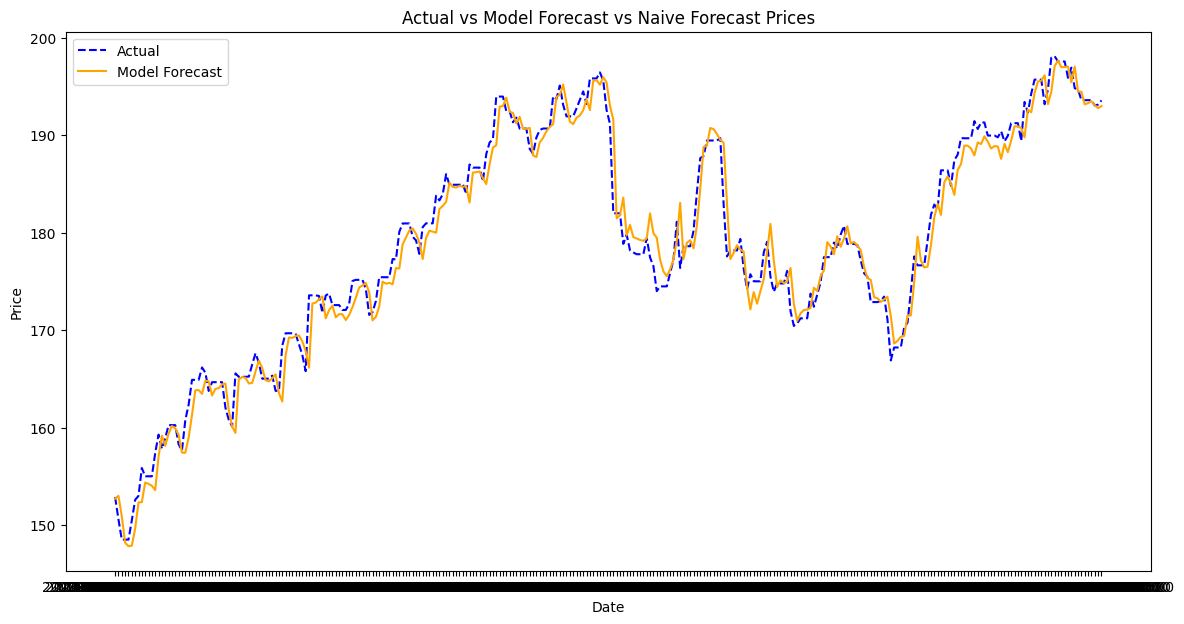

In [44]:
plt.figure(figsize=(14, 7))
plt.plot(results_df['predict_date'], results_df['y_actual'], label='Actual', color='blue', linestyle='--')
plt.plot(results_df['predict_date'], results_df['raw_forecast'], label='Model Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Model Forecast vs Naive Forecast Prices')
plt.legend()
plt.show()

In [45]:
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score

def calculate_mse(context_results_df):
    return mean_squared_error(context_results_df['y_actual'], context_results_df['raw_forecast'])

def calculate_accuracy(context_results_df):
    correct_predictions = 0
    total_predictions = 0
    for i in range(1, len(context_results_df)):
        actual_today = context_results_df['y_actual'].iloc[i]
        predicted_today = context_results_df['raw_forecast'].iloc[i]
        actual_yesterday = context_results_df['y_actual'].iloc[i - 1]
        actual_movement = actual_today - actual_yesterday
        predicted_movement = predicted_today - actual_yesterday
        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            correct_predictions += 1
        total_predictions += 1

    return correct_predictions / total_predictions if total_predictions > 0 else 0

def calculate_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(1, len(context_results_df)):
        today_price = context_results_df['y_actual'].iloc[i]
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return capital - initial_capital

def calculate_actual_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['raw_forecast'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(2, len(context_results_df)):
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        yesterday_predicted_today_price = context_results_df['raw_forecast'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_predicted_today_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_predicted_today_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return capital - initial_capital

def calculate_results_for_context_len(context_len, results_by_context_len):
    # فیلتر کردن داده‌ها برای context_len مشخص شده
    context_results_df =results_by_context_len

    mse_value = calculate_mse(context_results_df)
    accuracy_value = calculate_accuracy(context_results_df)
    profit = calculate_profit(context_results_df)
    direction_accuracy = calculate_direction_accuracy(context_results_df)
    actual_direction_accuracy = calculate_actual_direction_accuracy(context_results_df)
    direction_profit = calculate_direction_profit(context_results_df)

    # ساخت دیکشنری از نتایج محاسبه شده
    result = {
        'context_len': context_len,
        'mse': mse_value,
        'accuracy': accuracy_value,
        'direction_accuracy': direction_accuracy,
        'actual_direction_accuracy': actual_direction_accuracy,
        'direction_profit': direction_profit,
        'profit': profit
    }

    return pd.DataFrame([result])

# فراخوانی تابع برای یک context_len خاص
context_len = 64  # برای مثال
final_result_df = calculate_results_for_context_len(context_len, results_df)
print(final_result_df)


   context_len       mse  accuracy  direction_accuracy  \
0           64  4.094569  0.345763            0.494915   

   actual_direction_accuracy  direction_profit    profit  
0                   0.576271          22.55872  3.251769  
